In [1]:
import librosa
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import scipy.signal as sps
from tabulate import tabulate
import pandas as pd
import statistics as stats
import pdb

# Prediction and Quantization
A simple signal processing system and its evaluation using commonly found metrics in signal processing and communications.

Parts
1. Using an IIR filter for "one-step-ahead" prediction
2. Using a quantizer to discretize sample values
3. Putting it all together
4. Bonus: Comparing performance

In [10]:
def signal_gen(frequency, amplitude, phase_degrees, duration, Fs):
    phase = phase_degrees * np.pi/180
    t  = np.arange(0,duration, 1/Fs) # X axis: Time & Samples
    return amplitude*np.sin(2*np.pi*frequency*t+phase), t


def dB(voltage):
    return 10 * np.log10(voltage)


def predict(signal, order):
    numerator = librosa.lpc(x, order) # Linear Filter Poles
    denominator = [1] 
    perr = sps.lfilter(numerator, denominator, x) 
    x_hat = x - perr
    print('Optimal coefficients: ' + str(numerator))
    return (x_hat, perr, numerator)


def quantize_predictor(predictor):
    a = np.array(predictor)
    for i in range(np.size(a)):
        if(np.abs(a[i]) >= 0.0 and np.abs(a[i]) < 0.5):
            a[i] = 0.10*np.sign(a[i])
        if(np.abs(a[i]) >= 0.5 and a[i] < 1.0):
            a[i] = 0.85*np.sign(a[i])
    print('Quantized coefficients: ' + str(a))
    return a


def quantize_error(err):
    series = np.array(err)
    for i in range(np.size(series)):
        if(np.abs(series[i]) < 0.05):
            series[i] = 0.0*np.sign(series[i])
        if(np.abs(series[i]) >= 0.05 and np.abs(series[i]) < 0.25):
            series[i] = 0.2*np.sign(series[i])
        if(np.abs(series[i]) >= 0.25 and np.abs(series[i]) < 0.50):
            series[i] = 0.4*np.sign(series[i])
        if(np.abs(series[i]) >= 0.50 and np.abs(series[i]) < 0.75):
            series[i] = 0.6*np.sign(series[i])
        if(np.abs(series[i]) >= 0.75 and np.abs(series[i]) < 1.0):
            series[i] = 0.9*np.sign(series[i])
        if(np.abs(series[i]) >= 1):
            series[i] = 1*np.sign(series[i])
    return series

### Example Predictor

Optimal coefficients: [ 1.         -0.28345083  0.7715677 ]


(-5, 5)

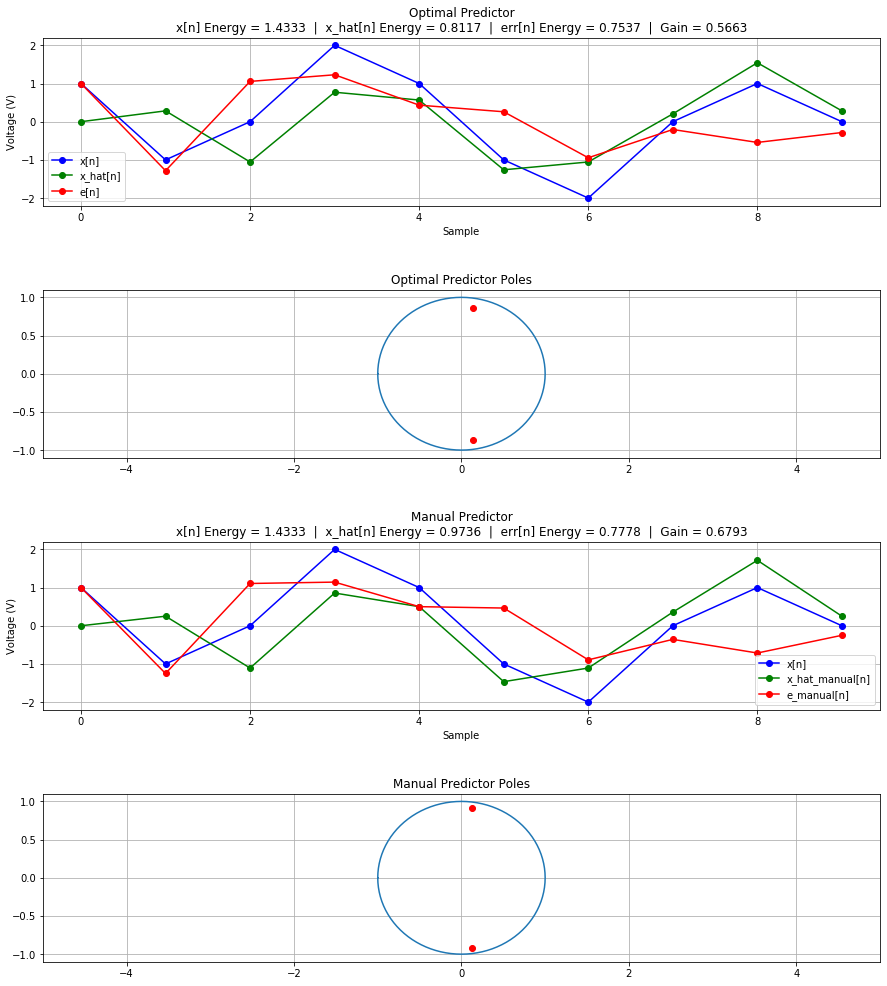

In [3]:
n = np.arange(0,10)
x = np.array([1.0,-1.0,0.0,2.0,1.0,-1.0,-2.0,0.0,1.0,0.0])
a_manual = [1.0000,-0.2500,0.8570]


# Optimal Coefficients
x_hat, perr, a = predict(x,2)


# Manual Coefficients
denominator  = [1] 
perr_manual  = sps.lfilter(a_manual, denominator, x) 
x_hat_manual = x - perr_manual


# Energy (variance of zero-mean signal = energy)
var_x     = stats.variance(x)
var_x_hat = stats.variance(x_hat)
var_perr  = stats.variance(perr)
var_x_hat_manual = stats.variance(x_hat_manual)
var_perr_manual  = stats.variance(perr_manual)


# Prediction gain calculation (E_prediction/E_x)
optimal_gain = var_x_hat/var_x
manual_gain  = var_x_hat_manual/var_x


# Obtaining Poles and zeroes of the filter
(zeroes_optimal, poles_optimal, k) = sps.tf2zpk(1,a)
(zeroes_manual, poles_manual, k) = sps.tf2zpk(1,a_manual)

# Graph
plt.figure('position', [15,17])
plt.subplots_adjust(hspace = 0.5)

plt.subplot(4,1,1)
plt.title('Optimal Predictor\n' 
         +'x[n] Energy = ' + str(np.round(var_x, 4)) + '  |  ' 
         +'x_hat[n] Energy = ' + str(np.round(var_x_hat, 4)) + '  |  ' 
         +'err[n] Energy = ' + str(np.round(var_perr, 4)) + '  |  '
         + 'Gain = ' + str(np.round(optimal_gain, 4)))
plt.plot(n, x, 'b-o', label='x[n]')
plt.plot(n, x_hat, 'g-o', label='x_hat[n]')
plt.plot(n, perr, 'r-o', label='e[n]')
plt.ylabel('Voltage (V)')
plt.xlabel('Sample')
plt.grid()
plt.legend()

plt.subplot(4,1,2)
theta = np.linspace(-np.pi,np.pi,201)
plt.plot(np.cos(theta),np.sin(theta))
plt.scatter(np.real(zeroes_optimal),np.imag(zeroes_optimal))
plt.scatter(np.real(poles_optimal),np.imag(poles_optimal), color='r')
plt.title("Optimal Predictor Poles")
plt.grid()
plt.xlim(-5,5)

plt.subplot(4,1,3)
plt.title('Manual Predictor\n'
         +'x[n] Energy = ' + str(np.round(var_x, 4)) + '  |  ' 
         +'x_hat[n] Energy = ' + str(np.round(var_x_hat_manual, 4)) + '  |  ' 
         +'err[n] Energy = ' + str(np.round(var_perr_manual, 4)) + '  |  '
         + 'Gain = ' + str(np.round(manual_gain, 4)))
plt.plot(n, x, 'b-o', label='x[n]')
plt.plot(n, x_hat_manual, 'g-o', label='x_hat_manual[n]')
plt.plot(n, perr_manual, 'r-o', label='e_manual[n]')
plt.ylabel('Voltage (V)')
plt.xlabel('Sample')
plt.grid()
plt.legend()

plt.subplot(4,1,4)
theta = np.linspace(-np.pi,np.pi,201)
plt.plot(np.cos(theta),np.sin(theta))
plt.scatter(np.real(zeroes_manual),np.imag(zeroes_manual))
plt.scatter(np.real(poles_manual),np.imag(poles_manual), color='r')
plt.title("Manual Predictor Poles")
plt.grid()
plt.xlim(-5,5)

### Predictor with .wav file

Optimal coefficients: [ 1.         -1.90764194  0.96751244]


(-5, 5)

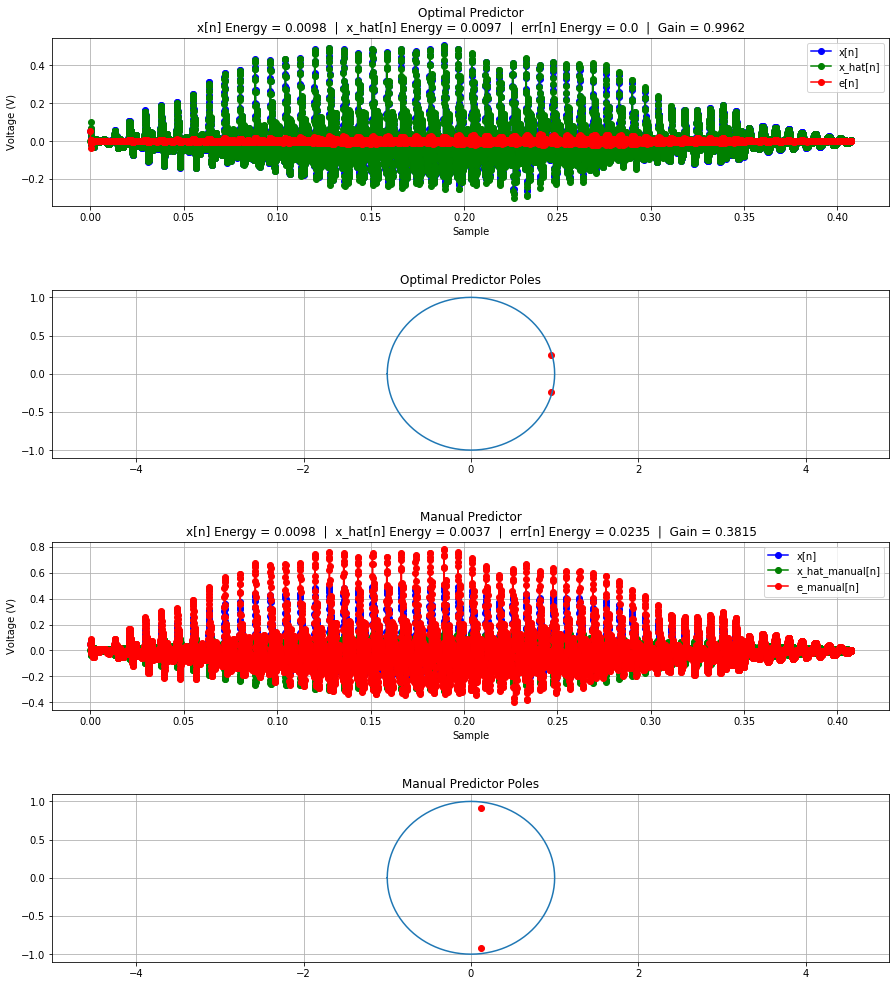

In [4]:
# Importing the signal
x, sr = librosa.load('snip.wav') # Signal time series and sampling rate
x = np.ndarray.tolist(x)
x = np.array(x)
duration = np.size(x)/sr
period = 1/sr
n = np.arange(0,duration, period)


# Coefficients
a_manual = [1.0000,-0.2500,0.8570]
x_hat, perr, a = predict(x,2)


# Manual Coefficients
denominator  = [1] 
perr_manual  = sps.lfilter(a_manual, denominator, x) 
x_hat_manual = x - perr_manual


# Energy (variance of zero-mean signal = energy)
var_x     = stats.variance(x)
var_x_hat = stats.variance(x_hat)
var_perr  = stats.variance(perr)
var_x_hat_manual = stats.variance(x_hat_manual)
var_perr_manual  = stats.variance(perr_manual)


# Prediction gain calculation (E_prediction/E_x)
optimal_gain = var_x_hat/var_x
manual_gain  = var_x_hat_manual/var_x


# Obtaining Poles and zeroes of the filter
(zeroes_optimal, poles_optimal, k) = sps.tf2zpk(1,a)
(zeroes_manual, poles_manual, k_manual) = sps.tf2zpk(1,a_manual)


# Graph
plt.figure('position', [15,17])
plt.subplots_adjust(hspace = 0.5)

plt.subplot(4,1,1)
plt.title('Optimal Predictor\n' 
         +'x[n] Energy = ' + str(np.round(var_x, 4)) + '  |  ' 
         +'x_hat[n] Energy = ' + str(np.round(var_x_hat, 4)) + '  |  ' 
         +'err[n] Energy = ' + str(np.round(var_perr, 4)) + '  |  '
         + 'Gain = ' + str(np.round(optimal_gain, 4)))
plt.plot(n, x, 'b-o', label='x[n]')
plt.plot(n, x_hat, 'g-o', label='x_hat[n]')
plt.plot(n, perr, 'r-o', label='e[n]')
plt.ylabel('Voltage (V)')
plt.xlabel('Sample')
plt.grid()
plt.legend()
# plt.xlim(.15,.17)
# plt.ylim(-0.1,.1)

plt.subplot(4,1,2)
theta = np.linspace(-np.pi,np.pi,201)
plt.plot(np.cos(theta),np.sin(theta))
plt.scatter(np.real(zeroes_optimal),np.imag(zeroes_optimal))
plt.scatter(np.real(poles_optimal),np.imag(poles_optimal), color='r')
plt.title("Optimal Predictor Poles")
plt.grid()
plt.xlim(-5,5)

plt.subplot(4,1,3)
plt.title('Manual Predictor\n'
         +'x[n] Energy = ' + str(np.round(var_x, 4)) + '  |  ' 
         +'x_hat[n] Energy = ' + str(np.round(var_x_hat_manual, 4)) + '  |  ' 
         +'err[n] Energy = ' + str(np.round(var_perr_manual, 4)) + '  |  '
         + 'Gain = ' + str(np.round(manual_gain, 4)))
plt.plot(n, x, 'b-o', label='x[n]')
plt.plot(n, x_hat_manual, 'g-o', label='x_hat_manual[n]')
plt.plot(n, perr_manual, 'r-o', label='e_manual[n]')
plt.ylabel('Voltage (V)')
plt.xlabel('Sample')
plt.grid()
plt.legend()

plt.subplot(4,1,4)
theta = np.linspace(-np.pi,np.pi,201)
plt.plot(np.cos(theta),np.sin(theta))
plt.scatter(np.real(zeroes_manual),np.imag(zeroes_manual))
plt.scatter(np.real(poles_manual),np.imag(poles_manual), color='r')
plt.title("Manual Predictor Poles")
plt.grid()
plt.xlim(-5,5)

### Answer the following questions
i. What is the difference between the optimal and non-optimal predictor coefficients in terms of the energy of the predicted (x_hat[n]) and error (e[n]) sequences? 

| Signal|  Optimal     | Non-optimal |
|:-----:|:------------:| -----:|
| x_hat | practicalt 1 | Drastically reduced |
| error | Just about 0 | Increased slightly |

ii. How does the optimal predictor improve the outcomes (think in terms of dB relative to the original sequence, or prediction gain)  

**Manual  -4.1851191736436535dB  
Optimal -0.01643260283363596dB**

iii. Why does the prediction gain improve when using the optimal predictor vs. the non-optimal predictor?  

**The non-optimal predictor amplifies the wrong portion of the spectrum**

iv. What should happen to the prediction gain if you increase the order of the prediction filter?  

**The gain will approach 0dB as the order increases**

Can you increase the order of the filter “too much” … ? Explain what happens, and why.  

**As the order increases, the starting values increase dramatically out of proportion and the filter
undergos deminishing returns. With an starting offset, it doesn't seem like there would be
a functional problem with the order of the filter besides computational resource usage.**


In [5]:
print('manual  '+str(dB(var_x_hat_manual/var_x)))
print('Optimal '+str(dB(var_x_hat/var_x)))

manual  -4.1851191736436535
Optimal -0.01643260283363596


### Part 2. Using a quantizer to discretize sample values
#### Quantizing the coefficients of the predictor

Optimal coefficients: [ 1.         -0.28345083  0.7715677 ]
Quantized coefficients: [ 1.   -0.1   0.85]


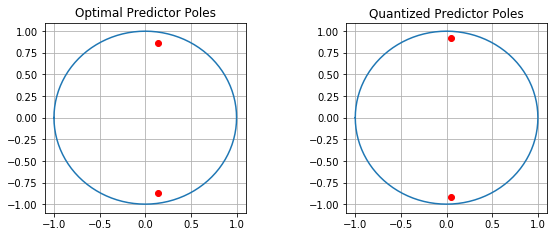

In [6]:
n = np.arange(0,10)
x = np.array([1.0,-1.0,0.0,2.0,1.0,-1.0,-2.0,0.0,1.0,0.0])


# Optimal Coefficients
x_hat, perr, a = predict(x,2)
a_quantized = quantize_predictor(a)


# Obtaining Poles and zeroes
(zeroes_optimal, poles_optimal, k) = sps.tf2zpk(1,a)
(zeroes_quantized, poles_quantized, k_quantized) = sps.tf2zpk(1,a_quantized)


# Plot
plt.figure('position', [9,3.5])
plt.subplots_adjust(hspace = 0.5, wspace=0.5)

plt.subplot(1,2,1)
plt.title("Optimal Predictor Poles")
theta = np.linspace(-np.pi,np.pi,201)
plt.plot(np.cos(theta),np.sin(theta))
plt.scatter(np.real(zeroes_optimal),np.imag(zeroes_optimal))
plt.scatter(np.real(poles_optimal),np.imag(poles_optimal), color='r')
plt.grid()

plt.subplot(1,2,2)
plt.title("Quantized Predictor Poles")
theta = np.linspace(-np.pi,np.pi,201)
plt.plot(np.cos(theta),np.sin(theta))
plt.scatter(np.real(zeroes_quantized),np.imag(zeroes_quantized))
plt.scatter(np.real(poles_quantized),np.imag(poles_quantized), color='r')
plt.grid()

#### Quantizing the coefficients of the error sequence

Optimal coefficients: [ 1.         -0.28345083  0.7715677 ]
1.0   ->   1.0
-1.2834508321825715   ->   -1.0
1.0550185333236426   ->   1.0
1.2284322988589287   ->   1.0
0.4330983356348572   ->   0.4
0.25968457009957113   ->   0.4
-0.9449814666763574   ->   -0.9
-0.20466603677592854   ->   -0.2
-0.5431354022821426   ->   -0.6
-0.2834508321825714   ->   -0.4


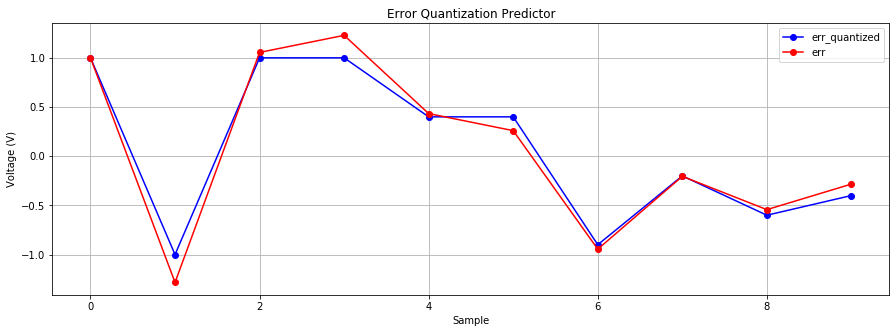

In [11]:
# Optimal Coefficients
x_hat, perr, a = predict(x,2)
err_quantized = quantize_error(perr)


# Numerically showing the difference
for i in range(np.size(perr)):
    print(str(perr[i])+'   ->   '+ str(err_quantized[i]))


# Graph
plt.figure('position', [15,5])
plt.subplots_adjust(hspace = 0.5)

plt.title('Error Quantization Predictor')
plt.plot(n, err_quantized, 'b-o', label='err_quantized')
plt.plot(n, perr, 'r-o', label='err')
plt.ylabel('Voltage (V)')
plt.xlabel('Sample')
plt.grid()
plt.legend()
# plt.xlim(.15,.17)
# plt.ylim(-0.1,.1)